# Homework 6

In [ ]:
import pandas as pd
import numpy as np
from sympy import Symbol, lambdify
import matplotlib.pyplot as plt

In [ ]:
train_data = pd.read_csv('Input/training.dat', sep=' ', header=None, names=['x', 'y']);
test_data = pd.read_csv('Input/test.dat', sep=' ', header=None, names=['x', 'y']);

x_train = np.array(train_data['x'])
y_train = np.array(train_data['y'])

norm_train = np.array(train_data)
norm_train = (norm_train - norm_train.mean(0)) / norm_train.std(0)

# comment out below lines to use normalized data

#x_train = norm_train[:,0]
#y_train = norm_train[:,1]

w0 = Symbol("w0")
w1 = Symbol("w1")
w2 = Symbol("w2")

func_a_coefficients = np.array([np.sum(y_train**2), 1*np.size(y_train), np.sum((x_train**2)), np.sum(2*y_train), np.sum(2*y_train*x_train), np.sum(2*x_train)])
func_a_variables = np.array([1, w0**2, w1**2, -w0, -w1, w0*w1])

func_b_coefficient = np.array([np.sum(y_train**2), 1*np.size(y_train), np.sum(x_train**2), np.sum(x_train**4), np.sum(2*y_train), np.sum(2*y_train*x_train), np.sum(2*y_train*x_train**2), np.sum(2*x_train), np.sum(2*x_train**2), np.sum(2*x_train**3)])
func_b_variables = np.array([1, w0**2, w1**2, w2**2, -w0, -w1, -w2, w0*w1, w0*w2, w1*w2])

func_a = np.sum(func_a_coefficients*func_a_variables)
f_a = lambdify([[w0, w1]], func_a, "numpy")
gf_a = lambdify([[w0, w1]], func_a.diff([[w0, w1]]), "numpy")
grad_fa = lambda x_arr : np.array(gf_a(x_arr), 'float64').reshape(1,len(x_arr))

func_b = np.sum(func_b_coefficient*func_b_variables)
f_b = lambdify([[w0, w1, w2]], func_b, "numpy")
gf_b = lambdify([[w0, w1, w2]], func_b.diff([[w0, w1, w2]]), "numpy")
grad_fb = lambda x_arr : np.array(gf_b(x_arr), 'float64').reshape(1,len(x_arr))

### Useful Functions

In [ ]:
regA = lambda w_s, x_arr : x_arr * w_s[1,0] + w_s[0,0]
regB = lambda w_s, x_arr : x_arr**2 * w_s[2,0] + x_arr * w_s[1,0] + w_s[0,0]

In [ ]:
def plotRegressionGraph(data, regFunc, w_star, title, name="graph"):
    xmin = data[:,0].min()
    xmax = data[:,0].max()
    t1 = np.arange(xmin-1, xmax+1, 0.1)
    plt.figure()
    plt.plot(t1, regFunc(w_star, t1), 'b-', label='Regression line')
    plt.scatter(data[:,0], data[:,1], color="black", label="Data points")
    plt.title(title)
    plt.legend()
    plt.savefig("{0}.png".format(name))

In [ ]:
np_str = lambda x_k : np.array2string(x_k.reshape(len(x_k)), precision=3, separator=',')

f_str = lambda x : "{0:.4f}".format(x)

In [ ]:
class OutputTable:    
    def __init__(self):
        self.table = pd.DataFrame([],columns=['k', 'x^k', 'f(x^k)', 'd^k', 'a^k', 'x^k+1'])
    def add_row(self, k, xk, fxk, dk, ak, xkp):
        self.table.loc[len(self.table)] = [k, np_str(xk), f_str(fxk.item()), np_str(dk), ak, np_str(xkp)]
    def print_latex(self):
        print(self.table.to_latex(index=False))

## Part A : Least Square Method with Steepest Descent

### Exact Line Search

In [ ]:
def BisectionMethod(f,epsilon, a=-100,b=100) :
    iteration=0
    while (b - a) >= epsilon:
        x_1 = (a + b) / 2
        fx_1 = f(x_1)
        if f(x_1 + epsilon) <= fx_1:
            a = x_1
        else:
            b = x_1
        iteration+=1
    x_star = (a+b)/2
    return x_star

def NewtonsMethod(df, ddf, x_0, epsilon, a, b):
    iteration = 0
    while True:
        dfx0 = df(x_0)
        ddfx0 = ddf(x_0)
        x_1 = x_0-dfx0/ddfx0
        iteration +=1
        if abs(x_0-x_1)<epsilon:
            break
        if x_1<a or x_1>b:
            break
        x_0 = x_1
    x_star = x_0
    return x_star

def ExactLineSearch(f, x0, d, eps=10**(-10)):
    alpha = Symbol('alpha')
    function_alpha = f(np.array(x0)+alpha*np.array(d)).item()
    f_alp = lambdify(alpha, function_alpha)
    bisecEps = 10**(-4)
    alp_star = BisectionMethod(f_alp, epsilon=bisecEps)
    df_alp = lambdify(alpha, function_alpha.diff(alpha))
    ddf_alp = lambdify(alpha, function_alpha.diff(alpha).diff(alpha))
    alp_star = NewtonsMethod(df_alp, ddf_alp, alp_star, eps, alp_star-bisecEps, alp_star+bisecEps)
    return alp_star

### Steepest Descent Method

In [ ]:
def steepestDescentMethod(f, grad_f, x_0, descentEpsilon, exactLineEpsilon=10**(-10)):
    xk = np.array(x_0).reshape(-1,1)
    k = 0
    stop = False
    output = OutputTable()
    while(stop == False):
        d = - np.transpose(grad_f(xk))
        if(np.linalg.norm(d) < descentEpsilon):
            stop = True
        else:
            a = ExactLineSearch(f,xk,d, exactLineEpsilon)
            xkp = xk + a*d
            output.add_row(k, xk, f(xk), d, a, xkp)
            k += 1
            xk = xkp
    output.add_row(k,xk,f(xk),d,None,np.array([]))
    print("Total iteration : {0}".format(k))
    return xk, f(xk).item(), output

In [ ]:
ws_a, fs_a, outputs_a = steepestDescentMethod(f_a, grad_fa, [0,0], 0.001)
ws_a, fs_a

Total iteration : 31


(array([[113.3499022 ],
        [  0.74045577]]), 3835642.7250205837)

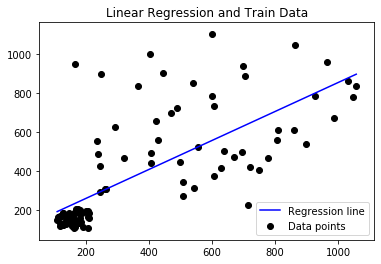

In [ ]:
plotRegressionGraph(np.array(train_data), regA, ws_a, "Linear Regression and Train Data")

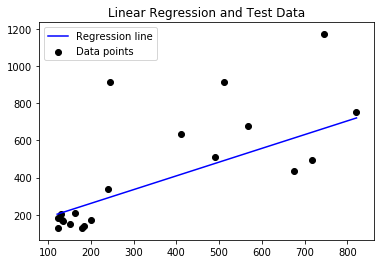

In [ ]:
plotRegressionGraph(np.array(test_data), regA, ws_a, "Linear Regression and Test Data")

In [ ]:
ws_b, fs_b, outputs_b = steepestDescentMethod(f_b, grad_fb, [0,0,0], 0.001)
ws_b, fs_b

In [ ]:
plotRegressionGraph(np.array(train_data), regB, ws_b)

## Part B : Neural Network

In [ ]:
sigmoidalFunc = lambda output_array : 1 / (1 + np.exp(-output_array))
sigmoidalDeriv = lambda hiddenlayer : hiddenlayer * (1 - hiddenlayer)

In [ ]:
def backpropagation(trainingData, hiddenLayerSize, alpha = 0.5, momentum = 0.9, epsilon = 0.001, seed = 440):
    np.random.seed(seed)
    t = 0
    patterns = np.copy(trainingData)
    patterns = np.insert(patterns, 0, -1, axis=1) # x0 = -1 unit is added
    P = np.size(patterns, 0) # pattern size
    I = 1 # output unit size
    K = np.size(patterns, 1) - I # input layer size
    J = hiddenLayerSize + 1 # h0 = -1 is added
    w_matrix = np.random.rand(J, K) # weights between input and hidden layer (we will exclude first row in the result since h0 is excluded)
    W_matrix = np.random.rand(I, J) # weight between hidden and output layer
    while(alpha >= epsilon):
        np.random.shuffle(patterns)
        x = np.transpose(patterns[:,:-1]).reshape(K, -1)
        y = patterns[:,-1]
        H = np.zeros(J)
        H[0] = -1 # h0 is equal to -1
        O = np.zeros_like(y)
        for p in range(P):
            for j in range(1,J):
                hj = np.sum(w_matrix[j] * x[:,p])
                H[j] = sigmoidalFunc(hj)
            for i in range(I):
                o = np.sum(W_matrix[i] * H)
                O[p] = o # linear function g(x) = x
            S_O = 0 # since there is only one output unit
            S_H = np.zeros_like(H)
            for i in range(I):
                S_O = 1 * (y[p] - O[p])
            for j in range(1,J):
                S_H[j] = sigmoidalDeriv(H[j]) * np.sum(W_matrix[0,j] * S_O)
            for j in range(J):
                dWj = alpha * S_O * H[j]
                W_matrix[0,j] += dWj
            for k in range(K):
                dwk = alpha * S_H * x[k,p]
                w_matrix[:,k] += dwk
        alpha *= momentum
        t += 1
        actualHiddens = sigmoidalFunc(w_matrix @ x)
        actualHiddens[0,:] = -1 # h1, ..., hj
        actualOutputMatrix = W_matrix @ actualHiddens # o1, ..., oi
        error = np.sum(np.square(y - actualOutputMatrix))
        #print("Iteration {0} : error = {1}".format(t,error))
    w_matrix = w_matrix[1:] # first row is removed since it corresponds to H0
    return w_matrix, W_matrix, error

In [ ]:
def backpropagationWithMatrix(patterns, hiddenLayerSize, alpha = 0.5, momentum = 0.9, epsilon = 0.001, seed = 440):
    np.random.seed(seed)
    t = 0
    P = np.size(patterns, 0)
    w_matrix = np.random.rand(hiddenLayerSize, np.size(patterns,1))*1 # patterns data includes y values, its column size is selected since we will add x0 to input layer
    W_matrix = np.random.rand(1, hiddenLayerSize+1)*1 # we will add h0 to hidden layer
    while(alpha > epsilon):
        np.random.shuffle(patterns)
        desiredOutputs = patterns[:,-1].reshape(-1,1)
        inputLayers = np.transpose(np.insert(patterns, 0, -1, axis=1)[:,:-1]) # x0 is added to all patterns and its value is -1, output values are excluded
        hiddenLayer = np.zeros((hiddenLayerSize+1, 1)) # hiddenlayersize doesn't include h0 so it's added
        hiddenLayer[0,:] = -1 # h0 is equal to -1
        actualOutput = np.zeros_like(desiredOutputs)
        for p in range(P):
            hiddenLayer[1:] = sigmoidalFunc(w_matrix @ inputLayers[:,p].reshape(-1,1))
            actualOutput[p] = W_matrix @ hiddenLayer
            # since the function is linear, net output is equal to actual output
            S_output = (1 * (desiredOutputs[p] - actualOutput[p])).reshape(-1,1)
            S_hidden = (sigmoidalDeriv(hiddenLayer[1:]) * (np.transpose(W_matrix[:,1:]) @ S_output)).reshape(-1,1)
            delta_W = alpha * S_output @ np.transpose(hiddenLayer)
            W_matrix += delta_W
            delta_w = alpha * S_hidden @ np.transpose(inputLayers[:,p].reshape(-1,1))
            w_matrix += delta_w
        alpha = momentum * alpha
        t += 1
        actualHiddens = sigmoidalFunc(w_matrix @ inputLayers) # h1, ..., hj
        actualOutputMatrix = W_matrix @ np.insert(actualHiddens, 0, -1, axis=0) # o1, ..., oi
        error = np.sum(np.square(desiredOutputs - np.transpose(actualOutputMatrix)))
        #print("Iteration {0} : error = {1}".format(t,error))
    return w_matrix, W_matrix, error

In [ ]:
patterns = np.array(train_data)
backpropagation(patterns, 3, seed=440)

/home/akin/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


(array([[ 8.47339514e-01,  3.97995080e-01],
        [ 6.16147498e-01,  6.29039082e-01],
        [ 3.13448399e+02, -3.69468170e+04]]),
 array([[-127.77235014,  128.42128315,  128.78880676,  249.38554076]]),
 7954415.602024415)

In [ ]:
patterns = np.array(train_data)
backpropagationWithMatrix(patterns, 3, seed=50)

/home/akin/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


(array([[  0.62495165, -21.52694768],
        [  0.25547392,   0.39632991],
        [  0.3773151 ,   0.99657423]]),
 array([[-128.24385088, 1238.84623456,  129.41258477,  128.96205743]]),
 7953714.347670076)

In [ ]:
patterns2 = np.insert(np.array(train_data), 1, np.square(train_data['x']), axis=1)
backpropagation(patterns2, 3)

(array([[0.39799508, 0.6161475 , 0.62903908],
        [0.15285732, 0.17501496, 0.38176556],
        [0.26716745, 0.63469106, 0.28434213]]),
 array([[-96.51737743,  98.39875203,  98.06407988,  97.76263623]]),
 7954322.33853856)

In [ ]:
def averageError(w_matrix, W_matrix, test_data):
    inputLayers = np.transpose(np.insert(test_data, 0, -1, axis=1)[:,:-1]) # h1, ..., hj
    desiredOutputs = test_data[:,-1].reshape(-1,1)
    actualHiddens = sigmoidalFunc(w_matrix @ inputLayers)
    actualOutputMatrix = W_matrix @ np.insert(actualHiddens, 0, -1, axis=0) # o1, ..., oi
    squareResiduals = np.square(desiredOutputs - np.transpose(actualOutputMatrix))
    sse = np.sum(squareResiduals)
    mse = sse / np.size(desiredOutputs)
    variance = np.sum(np.square(mse-squareResiduals)) / (np.size(desiredOutputs) - 1)
    return mse, variance

In [ ]:
def hiddenUnit(train_data, test_data, Jq = 3, epsilon = 0.001, seed = 440):
    train = np.array(train_data)
    test = np.array(test_data)
    q = 1
    Et = np.infty
    while(True):
        patterns = np.copy(train)
        w, W, total_error = backpropagation(patterns, Jq, epsilon=epsilon, seed = seed)
        Etp, var = averageError(w, W, test)
        print("{0} hidden units : MSE = {1} , variance = {2}".format(Jq,Etp,var))
        if(Etp >= Et):
            break
        Jq += 1
        q += 1
        Et = Etp
    return Jq-1, Et

In [ ]:
hiddenUnit(train_data, test_data, epsilon=0.001, seed = 440)

/home/akin/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
3 hidden units : MSE = 99809.23449953625 , variance = 21303014605.258526
4 hidden units : MSE = 99769.40473595812 , variance = 21230429635.30169
5 hidden units : MSE = 99539.03958209316 , variance = 20795803720.511967
6 hidden units : MSE = 99572.37714493924 , variance = 20860392979.14613


(5, 99539.03958209316)

In [ ]:
train_d = np.insert(np.array(train_data), 1, np.square(train_data['x']), axis=1)
test_d = np.insert(np.array(test_data), 1, np.square(test_data['x']), axis=1)
hiddenUnit(train_d, test_d)

3 hidden units : MSE = 99377.58914272355 , variance = 20473670331.01753
4 hidden units : MSE = 99756.81719579452 , variance = 21207344327.7232


(3, 99377.58914272355)